In [309]:
from preprocessing_compas import preprocessing_funct_not_enc, encoding_funct, K_subgroups_dataset_and_or, metrics_to_compare,encoding_funct_SMOTE
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
import torch

from divexplorer import DivergenceExplorer
from divexplorer import DivergencePatternProcessor
from divexplorer.outcomes import get_false_negative_rate_outcome
from divexplorer import DivergenceExplorer
from divexplorer import DivergencePatternProcessor  

In [310]:
'''smote_nc = SMOTENC(categorical_features=categorical_features,random_state=seed)
X_to_SMOTE, y_to_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
count_1 = y_to_SMOTE.sum()
count_0 = len(y_to_SMOTE)-count_1
count_0, count_1'''

'smote_nc = SMOTENC(categorical_features=categorical_features,random_state=seed)\nX_to_SMOTE, y_to_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)\ncount_1 = y_to_SMOTE.sum()\ncount_0 = len(y_to_SMOTE)-count_1\ncount_0, count_1'

In [311]:
# Carica il CSV
df = pd.read_csv("cox-violent-parsed.csv")

In [312]:
torch.manual_seed(42)
seed = 42
pd.options.display.float_format = '{:.3f}'.format

In [313]:
pruning = 0.00
epsilon = pruning
min_sup = 0.25
percentage = 80

In [314]:
df_train, df_val, df_test, df_holdout = preprocessing_funct_not_enc(df)
#controllo divisione dataset
print(f"TRAIN SET ROWS: ", df_train.shape[0]) 
print(f"VALIDATION SET ROWS: ", df_val.shape[0])
print(f"HOLDOUT SET ROWS: ", df_holdout.shape[0])
print(f"TEST SET ROWS: ", df_test.shape[0])

TRAIN SET ROWS:  10975
VALIDATION SET ROWS:  2439
HOLDOUT SET ROWS:  2440
TEST SET ROWS:  2439


In [315]:
df_train_enc, df_test_enc, df_holdout_enc, df_val_enc = encoding_funct(df_train=df_train, df_test=df_test, df_holdout=df_holdout, df_val=df_val)
#controllo coerenza con numerosità precedente
print(f"TRAIN SET ROWS: ", df_train_enc.shape[0]) #su 32536, il 40%  dovrebbe essere circa 13014
print(f"VALIDATION SET ROWS: ", df_val_enc.shape[0]) #su 32536, il 20%  dovrebbe essere circa 6500
print(f"HOLDOUT SET ROWS: ", df_holdout_enc.shape[0])
print(f"TEST SET ROWS: ", df_test_enc.shape[0])

TRAIN SET ROWS:  10975
VALIDATION SET ROWS:  2439
HOLDOUT SET ROWS:  2440
TEST SET ROWS:  2439


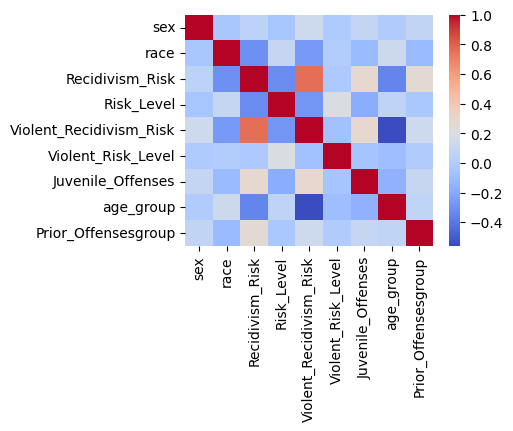

In [316]:
df_train_no_Violent_Recidivist = df_train_enc.drop(columns = 'Violent_Recidivist')
plt.figure(figsize=(4, 3))
g = sns.heatmap(df_train_no_Violent_Recidivist.corr(),
                annot = False,
                cmap = "coolwarm")

In [317]:
#DECISION TREE CLASSIFIER
X_train = df_train_enc.drop(columns = 'Violent_Recidivist', axis = 1)
y_train = df_train_enc['Violent_Recidivist']

X_test = df_test_enc.drop(columns = 'Violent_Recidivist', axis = 1)
y_test = df_test_enc['Violent_Recidivist']

X_val = df_val_enc.drop(columns = 'Violent_Recidivist', axis = 1)
y_val = df_val_enc['Violent_Recidivist']

X_holdout = df_holdout_enc.drop(columns = 'Violent_Recidivist', axis = 1)
y_holdout = df_holdout_enc['Violent_Recidivist']

classifier_train = DecisionTreeClassifier(random_state=seed)
classifier_train.fit(X_train, y_train)
y_pred = classifier_train.predict(X_test)
cm_classifier = confusion_matrix(y_test, y_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm_classifier, display_labels=[False, True])
#disp.plot()
#plt.show()
accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before = metrics_to_compare(y_true = y_test, y_pred = y_pred )
metrics_before_df = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_test)],
})
metrics_before_df = metrics_before_df.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Test Size']

for metric in metrics_to_cast:
    metrics_before_df[metric] = metrics_before_df[metric].astype(int)

metrics_before_df


Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Test Size
Before Mitigation,0.926,0.327,0.021,0.753,47,134,2439


SUBGROUPS SEARCH

-Identifico i gruppi applicando DivExplorer sul validation not encoded (a cui ho aggiunto la feature sui falsi positivi da passare a boolean outcomes e la feature accuracy che vale 1 se la predizione è giusta e 0 se sbagliata )

-Integro nel training set dati che matchano sottogruppi problematici prendendoli dall'holdout, (primi K = 5, tutte le righe holdout che matchano)

-Ripeto training e test

In [318]:
#predizioni per il validation set, queste mi servono solo per il div explorer che ha bisogno di ground truth e predizioni
y_pred_val = classifier_train.predict(X_val)

df_val_class = X_val.copy()
df_val_class['y_val_true'] = y_val
df_val_class['y_pred'] = y_pred_val

df_val_class.head()

,sex,race,Recidivism_Risk,Risk_Level,Violent_Recidivism_Risk,Violent_Risk_Level,Juvenile_Offenses,age_group,Prior_Offensesgroup,y_val_true,y_pred
10676,1,0,4,1,2,1,0,3,7,0,0
13123,1,2,1,1,1,1,0,3,0,0,0
2611,1,0,8,0,6,2,2,2,1,0,0
7945,1,2,1,1,1,1,0,5,0,0,0
5727,1,2,6,2,6,2,0,1,0,0,0


In [319]:
y_trues = df_val_class["y_val_true"]
y_preds = df_val_class["y_pred"]

df_val_class["fn"] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature "fn" a df_val non encoded
df_val["fn"] = df_val_class["fn"]

#aggiungo la feature accuracy a df_val non encoded che assume valore 1 se la predizione è giusta 0 se la predizione è sbagliata
#come controllo che sia corretto aggiungo la feature y_pred 
df_val['y_pred'] = df_val_class['y_pred'] 
df_val['accuracy'] = (df_val_class['y_val_true']==df_val_class['y_pred']).astype(int)
df_val.head()


,sex,race,Recidivism_Risk,Violent_Recidivist,Risk_Level,Violent_Recidivism_Risk,Violent_Risk_Level,Juvenile_Offenses,age_group,Prior_Offensesgroup,fn,y_pred,accuracy
10676,Male,African-American,4,0,Low,2,Low,0,45-54,6-10,NaN,0,1
13123,Male,Caucasian,1,0,Low,1,Low,0,45-54,0-5,NaN,0,1
2611,Male,African-American,8,0,High,6,Medium,2,35-44,11-15,NaN,0,1
7945,Male,Caucasian,1,0,Low,1,Low,0,65-100,0-5,NaN,0,1
5727,Male,Caucasian,6,0,Medium,6,Medium,0,25-34,0-5,NaN,0,1


ANALISI CONDOTTA CON LA FEATURE FP (PASSATA A BOOLEAN OUTCOME)

In [320]:
df_val

,sex,race,Recidivism_Risk,Violent_Recidivist,Risk_Level,Violent_Recidivism_Risk,Violent_Risk_Level,Juvenile_Offenses,age_group,Prior_Offensesgroup,fn,y_pred,accuracy
10676,Male,African-American,4,0,Low,2,Low,0,45-54,6-10,NaN,0,1
13123,Male,Caucasian,1,0,Low,1,Low,0,45-54,0-5,NaN,0,1
2611,Male,African-American,8,0,High,6,Medium,2,35-44,11-15,NaN,0,1
7945,Male,Caucasian,1,0,Low,1,Low,0,65-100,0-5,NaN,0,1
5727,Male,Caucasian,6,0,Medium,6,Medium,0,25-34,0-5,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4183,Male,Caucasian,1,0,Low,1,Low,0,55-64,0-5,NaN,0,1
9445,Male,Caucasian,8,0,High,9,High,21,25-34,16-20,NaN,0,1
8674,Female,Caucasian,5,0,Medium,4,Low,0,55-64,11-15,NaN,0,1
6392,Male,Hispanic,1,0,Low,1,Low,0,35-44,0-5,NaN,0,1


In [321]:
attributes = ['sex', 'race', 'Recidivism_Risk', 'Risk_Level', 'Violent_Recidivism_Risk', 'Violent_Risk_Level', 'Juvenile_Offenses', 'age_group', 'Prior_Offensesgroup']

In [322]:
fp_diver = DivergenceExplorer(df_val)
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=["fn"])
FP_fm = FP_fm.sort_values(by=["fn_div", "fn_t"], ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
FP_fm.head()

,support,itemset,fn,fn_div,fn_t,length,support_count
0,0.359,"(Risk_Level=Low, Violent_Risk_Level=Low, Prior_Offensesgroup=0-5)",1.000,0.190,4.358,3,876.000
1,0.349,"(Risk_Level=Low, Violent_Risk_Level=Low, Prior_Offensesgroup=0-5, Juvenile_Offenses=0)",1.000,0.190,4.293,4,850.000
2,0.267,"(Risk_Level=Low, Violent_Risk_Level=Low, sex=Male, Prior_Offensesgroup=0-5)",1.000,0.190,3.764,4,652.000
3,0.255,"(Prior_Offensesgroup=0-5, age_group=25-34, Juvenile_Offenses=0)",1.000,0.190,3.764,3,622.000
4,0.259,"(Prior_Offensesgroup=0-5, sex=Male, Risk_Level=Low, Violent_Risk_Level=Low, Juvenile_Offenses=0)",1.000,0.190,3.675,5,631.000


In [323]:
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, "fn")
df_pruned_fp = FP_fm
df_pruned_fp = df_pruned_fp = FP_fm
df_pruned_fp.head()

,support,itemset,fn,fn_div,fn_t,length,support_count
0,0.359,"(Risk_Level=Low, Violent_Risk_Level=Low, Prior_Offensesgroup=0-5)",1.000,0.190,4.358,3,876.000
1,0.349,"(Risk_Level=Low, Violent_Risk_Level=Low, Prior_Offensesgroup=0-5, Juvenile_Offenses=0)",1.000,0.190,4.293,4,850.000
2,0.267,"(Risk_Level=Low, Violent_Risk_Level=Low, sex=Male, Prior_Offensesgroup=0-5)",1.000,0.190,3.764,4,652.000
3,0.255,"(Prior_Offensesgroup=0-5, age_group=25-34, Juvenile_Offenses=0)",1.000,0.190,3.764,3,622.000
4,0.259,"(Prior_Offensesgroup=0-5, sex=Male, Risk_Level=Low, Violent_Risk_Level=Low, Juvenile_Offenses=0)",1.000,0.190,3.675,5,631.000


In [324]:
# Numero totale di istanze
total_instances = len(df_pruned_fp)

# Numero di istanze con fp_div > 0 e fp_t > 2
filtered_instances = len(df_pruned_fp[(df_pruned_fp["fn_div"] > 0) & (df_pruned_fp["fn_t"] > 2)])

print('total subgroups', total_instances)
print('total problematic', filtered_instances)

total subgroups 52
total problematic 26


In [325]:
prun_size = df_pruned_fp.shape
original_size = FP_fm.shape
print("Dim original: ", original_size)
print("Dim pruned th_redundancy ", prun_size)

Dim original:  (52, 7)
Dim pruned th_redundancy  (52, 7)


In [326]:
K = int((percentage / 100) * filtered_instances)
K

20

BIAS MITIGATION: ADDING DATA: prendo dati dall'hold-out e li aggiungo al train set, questi dati matchano gli itemset trovati prima (i primi 5)

1. prendo dati dall'holdout con la funzione K_subgroups_dataset_and_or li aggiungo train 
2. riapplico encoding tutto
3. Decision tree nuovamente e vedo come sono cambiate le performance (ad es Accuracy, false positive rate, false negative rate) overall e per sottogruppi

In [327]:
df_holdout_filtered = K_subgroups_dataset_and_or(df_pruned_fp, df_holdout, K) #da aggiungere a train set e ripetere train e test
df_holdout_filtered_solo0 = df_holdout_filtered[df_holdout_filtered['Violent_Recidivist']==0]



df_combinated = pd.concat([df_holdout_filtered_solo0, df_train], ignore_index=True)
df_train_mitigated= df_combinated.sample(frac=1, random_state=seed).reset_index(drop=True)

df_holdout_filtered = df_holdout_filtered_solo0 

In [328]:
print(len(df_holdout_filtered))

659


In [329]:
#riapplico funzione di encoding, ma al posto di holdout, uso il df filtrato che devo usare per inserire dati 
df_train_enc_mit, inutile1, inutile3, inutile2 = encoding_funct(df_train=df_train_mitigated, df_test=df_test, df_holdout=df_holdout_filtered, df_val=df_val)
#controllo divisione dataset
df_train_enc_mit_fp = df_train_enc_mit  
print(f"TRAIN SET ROWS: ", df_train_enc.shape[0])
print(f"TRAIN SET MITIGATED ROWS: ", df_train_enc_mit.shape[0]) #su 32536, il 40%  dovrebbe essere circa 13014
print(f"VALIDATION SET ROWS: ", inutile1.shape[0]) #su 32536, il 20%  dovrebbe essere circa 6500
print(f"FILTERED DF holdout ROWS: ", inutile3.shape[0])
print(f"TEST SET FILTERED ROWS: ", inutile2.shape[0])

TRAIN SET ROWS:  10975
TRAIN SET MITIGATED ROWS:  11634
VALIDATION SET ROWS:  2439
FILTERED DF holdout ROWS:  659
TEST SET FILTERED ROWS:  2439


In [330]:
X_train_mitigated = df_train_enc_mit.drop(columns = 'Violent_Recidivist', axis = 1)
y_train_mitigated = df_train_enc_mit['Violent_Recidivist']


classifier_train_mitigated = DecisionTreeClassifier(random_state=seed)

classifier_train_mitigated.fit(X_train_mitigated, y_train_mitigated)
y_mitigated_pred = classifier_train_mitigated.predict(X_test)
#cm_dt = confusion_matrix(y_test, y_mitigated_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=[False, True])
#disp.plot()
#plt.show()

In [331]:
#per veriicare cosa accade se aggiungo in modo randomico lo stesso numero di righe al train, ripeto l'analisi facebdo mitigation con righe randomiche (uguali in numero)
print(len(df_holdout_filtered))
n = len(df_holdout_filtered)
df_holdout_sampled = df_holdout_enc.sample(n=len(df_holdout_filtered), replace=True, random_state=seed)
print("verifica :", len(df_holdout_sampled)) #verifica



df_combinated_random = pd.concat([df_holdout_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random= df_combinated_random.sample(frac=1, random_state=seed).reset_index(drop=True)

X_train_mitigated_random = df_train_mitigated_random.drop(columns="Violent_Recidivist", axis = 1)
y_train_mitigated_random = df_train_mitigated_random['Violent_Recidivist']

classifier_train_mitigated_random = DecisionTreeClassifier(random_state=seed)

classifier_train_mitigated_random.fit(X_train_mitigated_random, y_train_mitigated_random)
y_mitigated_pred_random = classifier_train_mitigated_random.predict(X_test)



659
verifica : 659


In [332]:
accuracy_fp_after, f1_score_fp_after, fpr_fp_after, fnr_fp_after, fp_fp_after, fn_fp_after = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred )
accuracy_fp_after_random, f1_score_fp_after_random, fpr_fp_after_random, fnr_fp_after_random, fp_fp_after_random, fn_fp_after_random= metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random)

metrics_after_fp = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After Mitigation(K=5, fp)': [accuracy_fp_after, f1_score_fp_after, fpr_fp_after, fnr_fp_after, fp_fp_after, fn_fp_after, len(y_train_mitigated), len(y_test)],
    'After RANDOM mitigation' : [accuracy_fp_after_random, f1_score_fp_after_random, fpr_fp_after_random, fnr_fp_after_random, fp_fp_after_random, fn_fp_after_random, len(y_train_mitigated_random), len(y_test)]
})
metrics_after_fp = metrics_after_fp.set_index('Metrics').T



metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp[metric] = metrics_after_fp[metric].astype(int)

metrics_after_fp

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.926,0.327,0.021,0.753,47,134,10975,2439
"After Mitigation(K=5, fp)",0.927,0.335,0.020,0.747,46,133,11634,2439
After RANDOM mitigation,0.925,0.330,0.022,0.747,50,133,11634,2439


ANALISI DIVERGENZE
Per vedere cosa accade ai sottogruppi: vedo cosa succede alle divergenze del test dopo la mitigation

In [333]:

#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class["fn"] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature "fn" a df_val non encoded
df_test["fn"] = df_test_class["fn"]

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)

FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=["fn"])
FP_fm = FP_fm.sort_values(by="fn_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, "fn")
df_pruned_fp = FP_fm
df_pruned_fp = df_pruned_fp = FP_fm
df_pruned_fp.head()



fp_div_list_no_mitigation  = df_pruned_fp["fn_div"].tolist()
#fp_div_list_no_mitigation

#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred 

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class["fn"] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature "fn" a df_val non encoded
df_test["fn"] = df_test_class["fn"]

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=["fn"])
FP_fm = FP_fm.sort_values(by="fn_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, "fn")
df_pruned_fp = FP_fm
df_pruned_fp = df_pruned_fp = FP_fm
df_pruned_fp.head()



fp_div_list_baseline1  = df_pruned_fp["fn_div"].tolist()
#fp_div_list_baseline1

#PER VEDERE COSA SUCCEDE ALLE DIVERGENZE DEI SOTTOGRUPPI CON MITIGATION RADOMICA
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class["fn"] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature "fn" a df_val non encoded
df_test["fn"] = df_test_class["fn"]

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
#attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=["fn"])
FP_fm = FP_fm.sort_values(by="fn_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, "fn")
df_pruned_fp = FP_fm
df_pruned_fp = df_pruned_fp = FP_fm
df_pruned_fp.head()



fp_div_list_random_per_confrontare_con_baseline1  = df_pruned_fp["fn_div"].tolist()
#fp_div_list_random_per_confrontare_con_baseline1

# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = abs(sum(fp_div_list_no_mitigation) / len(fp_div_list_no_mitigation))
media_fp_div_list_nomitigation_primi10 = abs(sum(fp_div_list_no_mitigation[:10]) / len(fp_div_list_no_mitigation[:10]))
media_fp_div_list_nomitigation_primi20 = abs(sum(fp_div_list_no_mitigation[:20]) / len(fp_div_list_no_mitigation[:20]))
media_fp_div_list_nomitigation_primi40 = abs(sum(fp_div_list_no_mitigation[:40]) / len(fp_div_list_no_mitigation[:40]))
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline1 = abs(sum(fp_div_list_baseline1) / len(fp_div_list_baseline1))
media_fp_div_list_baseline1_primi10 = abs(sum(fp_div_list_baseline1[:10]) / len(fp_div_list_baseline1[:10]))
media_fp_div_list_baseline1_primi20 = abs(sum(fp_div_list_baseline1[:20]) / len(fp_div_list_baseline1[:20]))
media_fp_div_list_baseline1_primi40 = abs(sum(fp_div_list_baseline1[:40]) / len(fp_div_list_baseline1[:40]))
fp_div_massimo_valore_assoluto_fp_div_baseline1 = max(abs(x) for x in fp_div_list_baseline1)

media_fp_div_list_random_per_confrontare_con_baseline1 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1) / len(fp_div_list_random_per_confrontare_con_baseline1))
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:10]) / len(fp_div_list_random_per_confrontare_con_baseline1[:10]))
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:20]) / len(fp_div_list_random_per_confrontare_con_baseline1[:20]))
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = abs(sum(fp_div_list_random_per_confrontare_con_baseline1[:40]) / len(fp_div_list_random_per_confrontare_con_baseline1[:40]))
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
    'After Mitigation(K=5 fp)': [
        accuracy_fp_after, f1_score_fp_after, media_fp_div_list_baseline1, fp_div_massimo_valore_assoluto_fp_div_baseline1,
        media_fp_div_list_baseline1_primi10, media_fp_div_list_baseline1_primi20, media_fp_div_list_baseline1_primi40, len(df_holdout_filtered)
    ],
    'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        len(df_holdout_filtered)
    ]
})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.926,0.327,0.143,0.247,0.245,0.229,0.185,0.000
After Mitigation(K=5 fp),0.927,0.335,0.147,0.253,0.251,0.234,0.190,659.000
After RANDOM Mitigation(K=5 fp),0.925,0.330,0.148,0.253,0.251,0.234,0.191,659.000


SEGUE CODICE USANDO SMOTE 
DIVIDO IN TRAIN, TEST E VALIDATION -- ora uso quelli gia esistenti
DIV EXPLORER SUL VALIDATION  -- già fatto 
GENERO NUOVI DATI CON SMOTE a partire dai dati di divexplorer sul validation
INSERISCO QUESTI NUOVI DATI NEL TRAIN SET

BIAS MITIGATION SMOTENC

- FISSO N VARIA p, p è la probabilità che il campione simulato sia di classe 0 qui (perchè voglio diminuire il numero di falsi positivi)
- FISSO p VARIA N 

In [334]:
from imblearn.over_sampling import SMOTENC
df_val_filtered = K_subgroups_dataset_and_or(df_pruned_fp, df_val, K)
print("Righe del dataset filtrato qunado K = 5",len(df_val_filtered))
#df_val_filtered.head() #var categoriche e numeriche 
#print(len(df_val_filtered)) #--2610 con = 5
df_val_filtered, inutile12, inutile222 = encoding_funct_SMOTE(df_val_filtered, df_test, df_holdout)
X_to_SMOTE =  df_val_filtered.drop(columns = ["fn", 'y_pred', 'accuracy', "Violent_Recidivist"], axis = 1)
y_to_SMOTE = df_val_filtered["Violent_Recidivist"]
X_to_SMOTE.head()

categorical_features = [0, 1, 7, 8]

Righe del dataset filtrato qunado K = 5 868


In [335]:
count_1 = df_val_filtered["Violent_Recidivist"].sum()
count_0 = len(df_val_filtered) - count_1
count_1, count_0

(95, 773)

per confronto con targeted
N come len_df_holdout_filtered

In [336]:
p_values = np.arange(0.5, 1.05, 0.05)
p_values = np.round(p_values, 2).tolist()
p_values

[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]

N come holdout filtered e targeted acquisition

In [337]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTENC
from sklearn.tree import DecisionTreeClassifier

# Dizionari per salvare i risultati
X_train_mit_SMOTE_dict = {}
y_train_mit_SMOTE_dict = {}
y_pred_SMOTE_dict = {}
metrics_results_compare = {}
fp_div_results = {}

N = len(df_holdout_filtered)
original_size = len(X_to_SMOTE)

for p in p_values:
    sampling_strategy = {1: count_1 + int(N * p), 0: count_0 + int(N * (1 - p))}
    
    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)
    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
    
    X_generated = X_sampled_SMOTE[-N:]
    y_generated = y_sampled_SMOTE[-N:]
    
    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=True)
    
    classifier = DecisionTreeClassifier(random_state=seed)
    classifier.fit(X_train_mit_SMOTE_dict[p], y_train_mit_SMOTE_dict[p])
    y_pred_SMOTE_dict[p] = classifier.predict(X_test)
    
    metrics_results_compare[p] = metrics_to_compare(y_true=y_test, y_pred=y_pred_SMOTE_dict[p])
    
    df_test_class = X_test.copy()
    df_test_class['y_test_true'] = y_test
    df_test_class['y_pred'] = y_pred_SMOTE_dict[p]
    df_test_class["fn"] = get_false_negative_rate_outcome(df_test_class["y_test_true"], df_test_class["y_pred"])
    
    df_test["fn"] = df_test_class["fn"]
    df_test['y_pred'] = df_test_class['y_pred']
    
    fp_diver = DivergenceExplorer(df_test)
    attributes = attributes
    
    FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=["fn"])
    FP_fm = FP_fm.sort_values(by="fn_div", ascending=False, ignore_index=True)
    
    fp_details = DivergencePatternProcessor(FP_fm, "fn")
    df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
    df_pruned_fp = df_pruned_fp = FP_fm
    
    fp_div_results[p] = df_pruned_fp["fn_div"].tolist()

# Valori randomici per confronto senza mitigazione
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace=True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="Violent_Recidivist", axis=1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote["Violent_Recidivist"]

classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true=y_test, y_pred=y_mitigated_pred_random_smote_p)

metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = {}'.format(N): [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)]
})

for p in p_values:
    metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = list(metrics_results_compare[p]) + [len(X_train_mit_SMOTE_dict[p]), len(y_pred_SMOTE_dict[p])]

metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

# Mostrare la tabella finale
metrics_after_fp_SMOTE



Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.926,0.327,0.021,0.753,47,134,10975,2439
After RANDOM mitigation N = 659,0.925,0.330,0.022,0.747,50,133,11634,2439
After SMOTE N = 659 p_class 1 = 0.5,0.927,0.335,0.020,0.747,46,133,11634,2439
After SMOTE N = 659 p_class 1 = 0.55,0.926,0.337,0.022,0.742,49,132,11634,2439
After SMOTE N = 659 p_class 1 = 0.6,0.920,0.311,0.027,0.753,61,134,11634,2439
After SMOTE N = 659 p_class 1 = 0.65,0.925,0.320,0.021,0.758,48,135,11634,2439
After SMOTE N = 659 p_class 1 = 0.7,0.921,0.308,0.026,0.758,58,135,11634,2439
After SMOTE N = 659 p_class 1 = 0.75,0.927,0.344,0.021,0.736,48,131,11634,2439
After SMOTE N = 659 p_class 1 = 0.8,0.920,0.310,0.027,0.753,62,134,11634,2439
After SMOTE N = 659 p_class 1 = 0.85,0.925,0.326,0.021,0.753,48,134,11634,2439


In [338]:
# Dizionario per salvare i risultati della divergenza
fp_div_results = {}

# Lista degli esperimenti con l'ordine desiderato
experiments = {
    "no_mitigation": y_pred,  # Prima Before Mitigation
    "random": y_mitigated_pred_random,  # Poi Random
    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p
}

# Iteriamo su ogni esperimento nell'ordine corretto
for exp_name, preds in experiments.items():
    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni
    if exp_name == "SMOTE":
        iter_values = preds  # Lista dei valori di p
    else:
        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario

    for p in iter_values:
        # Creazione del DataFrame per il test set
        df_test_class = X_test.copy()
        df_test_class['y_test_true'] = y_test
        
        # Se l'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore
        df_test_class['y_pred'] = y_pred_SMOTE_dict[p] if exp_name == "SMOTE" else preds

        # Calcolo falsi positivi
        y_trues = df_test_class["y_test_true"]
        y_preds = df_test_class["y_pred"]
        df_test_class["fn"] = get_false_negative_rate_outcome(y_trues, y_preds)

        # Aggiunta delle feature calcolate a df_test
        df_test["fn"] = df_test_class["fn"]
        df_test['y_pred'] = df_test_class['y_pred']

        # Analisi della divergenza
        fp_diver = DivergenceExplorer(df_test)
        attributes = attributes
        
        FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=["fn"])
        FP_fm = FP_fm.sort_values(by="fn_div", ascending=False, ignore_index=True)

        # Pruning
        fp_details = DivergencePatternProcessor(FP_fm, "fn")
        df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
        df_pruned_fp = df_pruned_fp = FP_fm

        # Salviamo i risultati in un dizionario con una chiave fissa per no_mitigation/random
        key = (exp_name, p) if exp_name == "SMOTE" else exp_name
        fp_div_results[key] = df_pruned_fp["fn_div"].tolist()

# Calcolo delle metriche dai risultati della divergenza
results = {
    key: {
        "media": np.nanmean(fp_div_list),
        "media_primi10": np.nanmean(fp_div_list[:10]),
        "media_primi20": np.nanmean(fp_div_list[:20]),
        "media_primi40": np.nanmean(fp_div_list[:40]),
        "massimo_valore_assoluto": np.nanmax(np.abs(fp_div_list))
    }
    for key, fp_div_list in fp_div_results.items()
}


# Creazione della tabella dei risultati con le nuove metriche
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positives', 'False Negatives', 'Total Errors', 
                'Mean Divergence', 'Max Divergence', 'Top 10 Div', 'Top 20 Div', 'Top 40 Div'],
    'Before Mitigation': [
        accuracy_before, f1_score_before, fp_before, fn_before, 
        fp_before + fn_before, results['no_mitigation']['media'], results['no_mitigation']['massimo_valore_assoluto'], 
        results['no_mitigation']['media_primi10'], results['no_mitigation']['media_primi20'], results['no_mitigation']['media_primi40']
    ],
    'After RANDOM mitigation N = {}'.format(N): [
        accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p + fn_fp_after_SMOTE_random_p,
        results['random']['media'], results['random']['massimo_valore_assoluto'],
        results['random']['media_primi10'], results['random']['media_primi20'], results['random']['media_primi40']
    ]
})

# Aggiunta delle colonne per ogni valore di p
for p in p_values:
    if ('SMOTE', p) in results:
        metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = [
            metrics_results_compare[p][0],  # Accuracy
            metrics_results_compare[p][1],  # F1 Score
            metrics_results_compare[p][4],  # False Positives
            metrics_results_compare[p][5],  # False Negatives
            metrics_results_compare[p][4] + metrics_results_compare[p][5],  # Total Errors
            results[('SMOTE', p)]['media'],
            results[('SMOTE', p)]['massimo_valore_assoluto'],
            results[('SMOTE', p)]['media_primi10'],
            results[('SMOTE', p)]['media_primi20'],
            results[('SMOTE', p)]['media_primi40']
        ]

# Trasformare la tabella in formato leggibile
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T

# Castare i valori interi per alcune metriche
metrics_to_cast = ['False Positives', 'False Negatives', 'Total Errors']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

metrics_after_fp_SMOTE_confronto = metrics_after_fp_SMOTE
metrics_after_fp_SMOTE_confronto



Metrics,Accuracy,F1 Score,False Positives,False Negatives,Total Errors,Mean Divergence,Max Divergence,Top 10 Div,Top 20 Div,Top 40 Div
Before Mitigation,0.926,0.327,47,134,181,0.143,0.247,0.245,0.229,0.185
After RANDOM mitigation N = 659,0.925,0.330,50,133,183,0.148,0.253,0.251,0.234,0.191
After SMOTE N = 659 p_class 1 = 0.5,0.927,0.335,46,133,179,0.146,0.253,0.249,0.232,0.187
After SMOTE N = 659 p_class 1 = 0.55,0.926,0.337,49,132,181,0.148,0.258,0.254,0.237,0.191
After SMOTE N = 659 p_class 1 = 0.6,0.920,0.311,61,134,195,0.145,0.247,0.245,0.229,0.186
After SMOTE N = 659 p_class 1 = 0.65,0.925,0.320,48,135,183,0.138,0.242,0.240,0.223,0.179
After SMOTE N = 659 p_class 1 = 0.7,0.921,0.308,58,135,193,0.138,0.242,0.240,0.223,0.179
After SMOTE N = 659 p_class 1 = 0.75,0.927,0.344,48,131,179,0.153,0.264,0.262,0.246,0.198
After SMOTE N = 659 p_class 1 = 0.8,0.920,0.310,62,134,196,0.145,0.247,0.245,0.229,0.186
After SMOTE N = 659 p_class 1 = 0.85,0.925,0.326,48,134,182,0.144,0.247,0.245,0.229,0.185


N = 500

In [339]:
N = 500
# Dizionari per salvare i risultati
X_train_mit_SMOTE_dict = {}
y_train_mit_SMOTE_dict = {}
y_pred_SMOTE_dict = {}
metrics_results_compare = {}
fp_div_results = {}


original_size = len(X_to_SMOTE)

for p in p_values:
    sampling_strategy = {1: count_1 + int(N * p), 0: count_0 + int(N * (1 - p))}
    
    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)
    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
    
    X_generated = X_sampled_SMOTE[-N:]
    y_generated = y_sampled_SMOTE[-N:]
    
    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=True)
    
    classifier = DecisionTreeClassifier(random_state=seed)
    classifier.fit(X_train_mit_SMOTE_dict[p], y_train_mit_SMOTE_dict[p])
    y_pred_SMOTE_dict[p] = classifier.predict(X_test)
    
    metrics_results_compare[p] = metrics_to_compare(y_true=y_test, y_pred=y_pred_SMOTE_dict[p])
    
    df_test_class = X_test.copy()
    df_test_class['y_test_true'] = y_test
    df_test_class['y_pred'] = y_pred_SMOTE_dict[p]
    df_test_class["fn"] = get_false_negative_rate_outcome(df_test_class["y_test_true"], df_test_class["y_pred"])
    
    df_test["fn"] = df_test_class["fn"]
    df_test['y_pred'] = df_test_class['y_pred']
    
    fp_diver = DivergenceExplorer(df_test)
    attributes = attributes
    
    FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=["fn"])
    FP_fm = FP_fm.sort_values(by="fn_div", ascending=False, ignore_index=True)
    
    fp_details = DivergencePatternProcessor(FP_fm, "fn")
    df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
    df_pruned_fp = df_pruned_fp = FP_fm
    
    fp_div_results[p] = df_pruned_fp["fn_div"].tolist()

# Valori randomici per confronto senza mitigazione
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace=True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="Violent_Recidivist", axis=1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote["Violent_Recidivist"]

classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true=y_test, y_pred=y_mitigated_pred_random_smote_p)

metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = {}'.format(N): [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)]
})

for p in p_values:
    metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = list(metrics_results_compare[p]) + [len(X_train_mit_SMOTE_dict[p]), len(y_pred_SMOTE_dict[p])]

metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

# Mostrare la tabella finale
metrics_after_fp_SMOTE



Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.926,0.327,0.021,0.753,47,134,10975,2439
After RANDOM mitigation N = 500,0.927,0.335,0.020,0.747,46,133,11475,2439
After SMOTE N = 500 p_class 1 = 0.5,0.925,0.319,0.022,0.758,49,135,11475,2439
After SMOTE N = 500 p_class 1 = 0.55,0.927,0.339,0.021,0.742,47,132,11475,2439
After SMOTE N = 500 p_class 1 = 0.6,0.926,0.327,0.021,0.753,47,134,11475,2439
After SMOTE N = 500 p_class 1 = 0.65,0.928,0.338,0.019,0.747,43,133,11475,2439
After SMOTE N = 500 p_class 1 = 0.7,0.924,0.321,0.023,0.753,52,134,11475,2439
After SMOTE N = 500 p_class 1 = 0.75,0.925,0.319,0.022,0.758,49,135,11475,2439
After SMOTE N = 500 p_class 1 = 0.8,0.925,0.319,0.022,0.758,49,135,11475,2439
After SMOTE N = 500 p_class 1 = 0.85,0.922,0.320,0.026,0.747,58,133,11475,2439


In [340]:
# Dizionario per salvare i risultati della divergenza
fp_div_results = {}

# Lista degli esperimenti con l'ordine desiderato
experiments = {
    "no_mitigation": y_pred,  # Prima Before Mitigation
    "random": y_mitigated_pred_random,  # Poi Random
    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p
}

# Iteriamo su ogni esperimento nell'ordine corretto
for exp_name, preds in experiments.items():
    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni
    if exp_name == "SMOTE":
        iter_values = preds  # Lista dei valori di p
    else:
        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario

    for p in iter_values:
        # Creazione del DataFrame per il test set
        df_test_class = X_test.copy()
        df_test_class['y_test_true'] = y_test
        
        # Se l'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore
        df_test_class['y_pred'] = y_pred_SMOTE_dict[p] if exp_name == "SMOTE" else preds

        # Calcolo falsi positivi
        y_trues = df_test_class["y_test_true"]
        y_preds = df_test_class["y_pred"]
        df_test_class["fn"] = get_false_negative_rate_outcome(y_trues, y_preds)

        # Aggiunta delle feature calcolate a df_test
        df_test["fn"] = df_test_class["fn"]
        df_test['y_pred'] = df_test_class['y_pred']

        # Analisi della divergenza
        fp_diver = DivergenceExplorer(df_test)
        attributes = attributes
        
        FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=["fn"])
        FP_fm = FP_fm.sort_values(by="fn_div", ascending=False, ignore_index=True)

        # Pruning
        fp_details = DivergencePatternProcessor(FP_fm, "fn")
        df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
        df_pruned_fp = df_pruned_fp = FP_fm

        # Salviamo i risultati in un dizionario con una chiave fissa per no_mitigation/random
        key = (exp_name, p) if exp_name == "SMOTE" else exp_name
        fp_div_results[key] = df_pruned_fp["fn_div"].tolist()

# Calcolo delle metriche dai risultati della divergenza
results = {
    key: {
        "media": np.nanmean(fp_div_list),
        "media_primi10": np.nanmean(fp_div_list[:10]),
        "media_primi20": np.nanmean(fp_div_list[:20]),
        "media_primi40": np.nanmean(fp_div_list[:40]),
        "massimo_valore_assoluto": np.nanmax(np.abs(fp_div_list))
    }
    for key, fp_div_list in fp_div_results.items()
}


# Creazione della tabella dei risultati con le nuove metriche
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positives', 'False Negatives', 'Total Errors', 
                'Mean Divergence', 'Max Divergence', 'Top 10 Div', 'Top 20 Div', 'Top 40 Div'],
    'Before Mitigation': [
        accuracy_before, f1_score_before, fp_before, fn_before, 
        fp_before + fn_before, results['no_mitigation']['media'], results['no_mitigation']['massimo_valore_assoluto'], 
        results['no_mitigation']['media_primi10'], results['no_mitigation']['media_primi20'], results['no_mitigation']['media_primi40']
    ],
    'After RANDOM mitigation N = {}'.format(N): [
        accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p + fn_fp_after_SMOTE_random_p,
        results['random']['media'], results['random']['massimo_valore_assoluto'],
        results['random']['media_primi10'], results['random']['media_primi20'], results['random']['media_primi40']
    ]
})

# Aggiunta delle colonne per ogni valore di p
for p in p_values:
    if ('SMOTE', p) in results:
        metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = [
            metrics_results_compare[p][0],  # Accuracy
            metrics_results_compare[p][1],  # F1 Score
            metrics_results_compare[p][4],  # False Positives
            metrics_results_compare[p][5],  # False Negatives
            metrics_results_compare[p][4] + metrics_results_compare[p][5],  # Total Errors
            results[('SMOTE', p)]['media'],
            results[('SMOTE', p)]['massimo_valore_assoluto'],
            results[('SMOTE', p)]['media_primi10'],
            results[('SMOTE', p)]['media_primi20'],
            results[('SMOTE', p)]['media_primi40']
        ]

# Trasformare la tabella in formato leggibile
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T

# Castare i valori interi per alcune metriche
metrics_to_cast = ['False Positives', 'False Negatives', 'Total Errors']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

metrics_after_fp_SMOTE_500 = metrics_after_fp_SMOTE
metrics_after_fp_SMOTE_500



Metrics,Accuracy,F1 Score,False Positives,False Negatives,Total Errors,Mean Divergence,Max Divergence,Top 10 Div,Top 20 Div,Top 40 Div
Before Mitigation,0.926,0.327,47,134,181,0.143,0.247,0.245,0.229,0.185
After RANDOM mitigation N = 500,0.927,0.335,46,133,179,0.148,0.253,0.251,0.234,0.191
After SMOTE N = 500 p_class 1 = 0.5,0.925,0.319,49,135,184,0.140,0.242,0.240,0.223,0.180
After SMOTE N = 500 p_class 1 = 0.55,0.927,0.339,47,132,179,0.152,0.258,0.257,0.240,0.196
After SMOTE N = 500 p_class 1 = 0.6,0.926,0.327,47,134,181,0.145,0.247,0.245,0.229,0.186
After SMOTE N = 500 p_class 1 = 0.65,0.928,0.338,43,133,176,0.148,0.253,0.251,0.234,0.191
After SMOTE N = 500 p_class 1 = 0.7,0.924,0.321,52,134,186,0.144,0.247,0.245,0.229,0.186
After SMOTE N = 500 p_class 1 = 0.75,0.925,0.319,49,135,184,0.140,0.242,0.240,0.223,0.181
After SMOTE N = 500 p_class 1 = 0.8,0.925,0.319,49,135,184,0.140,0.242,0.240,0.223,0.181
After SMOTE N = 500 p_class 1 = 0.85,0.922,0.320,58,133,191,0.148,0.253,0.251,0.234,0.190


N = 1000

In [341]:
N = 1000
# Dizionari per salvare i risultati
X_train_mit_SMOTE_dict = {}
y_train_mit_SMOTE_dict = {}
y_pred_SMOTE_dict = {}
metrics_results_compare = {}
fp_div_results = {}


original_size = len(X_to_SMOTE)

for p in p_values:
    sampling_strategy = {1: count_1 + int(N * p), 0: count_0 + int(N * (1 - p))}
    
    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)
    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
    
    X_generated = X_sampled_SMOTE[-N:]
    y_generated = y_sampled_SMOTE[-N:]
    
    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=True)
    
    classifier = DecisionTreeClassifier(random_state=seed)
    classifier.fit(X_train_mit_SMOTE_dict[p], y_train_mit_SMOTE_dict[p])
    y_pred_SMOTE_dict[p] = classifier.predict(X_test)
    
    metrics_results_compare[p] = metrics_to_compare(y_true=y_test, y_pred=y_pred_SMOTE_dict[p])
    
    df_test_class = X_test.copy()
    df_test_class['y_test_true'] = y_test
    df_test_class['y_pred'] = y_pred_SMOTE_dict[p]
    df_test_class["fn"] = get_false_negative_rate_outcome(df_test_class["y_test_true"], df_test_class["y_pred"])
    
    df_test["fn"] = df_test_class["fn"]
    df_test['y_pred'] = df_test_class['y_pred']
    
    fp_diver = DivergenceExplorer(df_test)
    attributes = attributes
    
    FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=["fn"])
    FP_fm = FP_fm.sort_values(by="fn_div", ascending=False, ignore_index=True)
    
    fp_details = DivergencePatternProcessor(FP_fm, "fn")
    df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
    df_pruned_fp = df_pruned_fp = FP_fm
    
    fp_div_results[p] = df_pruned_fp["fn_div"].tolist()

# Valori randomici per confronto senza mitigazione
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace=True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="Violent_Recidivist", axis=1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote["Violent_Recidivist"]

classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true=y_test, y_pred=y_mitigated_pred_random_smote_p)

metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = {}'.format(N): [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)]
})

for p in p_values:
    metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = list(metrics_results_compare[p]) + [len(X_train_mit_SMOTE_dict[p]), len(y_pred_SMOTE_dict[p])]

metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

# Mostrare la tabella finale
metrics_after_fp_SMOTE



Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.926,0.327,0.021,0.753,47,134,10975,2439
After RANDOM mitigation N = 1000,0.924,0.327,0.023,0.747,52,133,11975,2439
After SMOTE N = 1000 p_class 1 = 0.5,0.924,0.331,0.024,0.742,54,132,11975,2439
After SMOTE N = 1000 p_class 1 = 0.55,0.921,0.314,0.026,0.753,58,134,11975,2439
After SMOTE N = 1000 p_class 1 = 0.6,0.925,0.319,0.022,0.758,49,135,11975,2439
After SMOTE N = 1000 p_class 1 = 0.65,0.920,0.311,0.027,0.753,61,134,11975,2439
After SMOTE N = 1000 p_class 1 = 0.7,0.924,0.322,0.023,0.753,51,134,11975,2439
After SMOTE N = 1000 p_class 1 = 0.75,0.924,0.331,0.024,0.742,54,132,11975,2439
After SMOTE N = 1000 p_class 1 = 0.8,0.922,0.321,0.025,0.747,57,133,11975,2439
After SMOTE N = 1000 p_class 1 = 0.85,0.923,0.325,0.024,0.747,54,133,11975,2439


In [342]:
# Dizionario per salvare i risultati della divergenza
fp_div_results = {}

# Lista degli esperimenti con l'ordine desiderato
experiments = {
    "no_mitigation": y_pred,  # Prima Before Mitigation
    "random": y_mitigated_pred_random,  # Poi Random
    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p
}

# Iteriamo su ogni esperimento nell'ordine corretto
for exp_name, preds in experiments.items():
    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni
    if exp_name == "SMOTE":
        iter_values = preds  # Lista dei valori di p
    else:
        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario

    for p in iter_values:
        # Creazione del DataFrame per il test set
        df_test_class = X_test.copy()
        df_test_class['y_test_true'] = y_test
        
        # Se l'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore
        df_test_class['y_pred'] = y_pred_SMOTE_dict[p] if exp_name == "SMOTE" else preds

        # Calcolo falsi positivi
        y_trues = df_test_class["y_test_true"]
        y_preds = df_test_class["y_pred"]
        df_test_class["fn"] = get_false_negative_rate_outcome(y_trues, y_preds)

        # Aggiunta delle feature calcolate a df_test
        df_test["fn"] = df_test_class["fn"]
        df_test['y_pred'] = df_test_class['y_pred']

        # Analisi della divergenza
        fp_diver = DivergenceExplorer(df_test)
        attributes = attributes
        
        FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=["fn"])
        FP_fm = FP_fm.sort_values(by="fn_div", ascending=False, ignore_index=True)

        # Pruning
        fp_details = DivergencePatternProcessor(FP_fm, "fn")
        df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
        df_pruned_fp = df_pruned_fp = FP_fm

        # Salviamo i risultati in un dizionario con una chiave fissa per no_mitigation/random
        key = (exp_name, p) if exp_name == "SMOTE" else exp_name
        fp_div_results[key] = df_pruned_fp["fn_div"].tolist()

# Calcolo delle metriche dai risultati della divergenza
results = {
    key: {
        "media": np.nanmean(fp_div_list),
        "media_primi10": np.nanmean(fp_div_list[:10]),
        "media_primi20": np.nanmean(fp_div_list[:20]),
        "media_primi40": np.nanmean(fp_div_list[:40]),
        "massimo_valore_assoluto": np.nanmax(np.abs(fp_div_list))
    }
    for key, fp_div_list in fp_div_results.items()
}


# Creazione della tabella dei risultati con le nuove metriche
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positives', 'False Negatives', 'Total Errors', 
                'Mean Divergence', 'Max Divergence', 'Top 10 Div', 'Top 20 Div', 'Top 40 Div'],
    'Before Mitigation': [
        accuracy_before, f1_score_before, fp_before, fn_before, 
        fp_before + fn_before, results['no_mitigation']['media'], results['no_mitigation']['massimo_valore_assoluto'], 
        results['no_mitigation']['media_primi10'], results['no_mitigation']['media_primi20'], results['no_mitigation']['media_primi40']
    ],
    'After RANDOM mitigation N = {}'.format(N): [
        accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p + fn_fp_after_SMOTE_random_p,
        results['random']['media'], results['random']['massimo_valore_assoluto'],
        results['random']['media_primi10'], results['random']['media_primi20'], results['random']['media_primi40']
    ]
})

# Aggiunta delle colonne per ogni valore di p
for p in p_values:
    if ('SMOTE', p) in results:
        metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = [
            metrics_results_compare[p][0],  # Accuracy
            metrics_results_compare[p][1],  # F1 Score
            metrics_results_compare[p][4],  # False Positives
            metrics_results_compare[p][5],  # False Negatives
            metrics_results_compare[p][4] + metrics_results_compare[p][5],  # Total Errors
            results[('SMOTE', p)]['media'],
            results[('SMOTE', p)]['massimo_valore_assoluto'],
            results[('SMOTE', p)]['media_primi10'],
            results[('SMOTE', p)]['media_primi20'],
            results[('SMOTE', p)]['media_primi40']
        ]

# Trasformare la tabella in formato leggibile
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T

# Castare i valori interi per alcune metriche
metrics_to_cast = ['False Positives', 'False Negatives', 'Total Errors']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

metrics_after_fp_SMOTE_1000 = metrics_after_fp_SMOTE
metrics_after_fp_SMOTE_1000



Metrics,Accuracy,F1 Score,False Positives,False Negatives,Total Errors,Mean Divergence,Max Divergence,Top 10 Div,Top 20 Div,Top 40 Div
Before Mitigation,0.926,0.327,47,134,181,0.143,0.247,0.245,0.229,0.185
After RANDOM mitigation N = 1000,0.924,0.327,52,133,185,0.148,0.253,0.251,0.234,0.191
After SMOTE N = 1000 p_class 1 = 0.5,0.924,0.331,54,132,186,0.150,0.258,0.257,0.240,0.194
After SMOTE N = 1000 p_class 1 = 0.55,0.921,0.314,58,134,192,0.145,0.247,0.245,0.229,0.186
After SMOTE N = 1000 p_class 1 = 0.6,0.925,0.319,49,135,184,0.140,0.242,0.240,0.223,0.180
After SMOTE N = 1000 p_class 1 = 0.65,0.920,0.311,61,134,195,0.144,0.247,0.245,0.229,0.185
After SMOTE N = 1000 p_class 1 = 0.7,0.924,0.322,51,134,185,0.144,0.247,0.245,0.229,0.185
After SMOTE N = 1000 p_class 1 = 0.75,0.924,0.331,54,132,186,0.152,0.258,0.257,0.240,0.195
After SMOTE N = 1000 p_class 1 = 0.8,0.922,0.321,57,133,190,0.146,0.253,0.249,0.232,0.188
After SMOTE N = 1000 p_class 1 = 0.85,0.923,0.325,54,133,187,0.148,0.253,0.251,0.234,0.191


N = 1500

In [343]:
N = 1500
# Dizionari per salvare i risultati
X_train_mit_SMOTE_dict = {}
y_train_mit_SMOTE_dict = {}
y_pred_SMOTE_dict = {}
metrics_results_compare = {}
fp_div_results = {}


original_size = len(X_to_SMOTE)

for p in p_values:
    sampling_strategy = {1: count_1 + int(N * p), 0: count_0 + int(N * (1 - p))}
    
    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)
    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
    
    X_generated = X_sampled_SMOTE[-N:]
    y_generated = y_sampled_SMOTE[-N:]
    
    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=True)
    
    classifier = DecisionTreeClassifier(random_state=seed)
    classifier.fit(X_train_mit_SMOTE_dict[p], y_train_mit_SMOTE_dict[p])
    y_pred_SMOTE_dict[p] = classifier.predict(X_test)
    
    metrics_results_compare[p] = metrics_to_compare(y_true=y_test, y_pred=y_pred_SMOTE_dict[p])
    
    df_test_class = X_test.copy()
    df_test_class['y_test_true'] = y_test
    df_test_class['y_pred'] = y_pred_SMOTE_dict[p]
    df_test_class["fn"] = get_false_negative_rate_outcome(df_test_class["y_test_true"], df_test_class["y_pred"])
    
    df_test["fn"] = df_test_class["fn"]
    df_test['y_pred'] = df_test_class['y_pred']
    
    fp_diver = DivergenceExplorer(df_test)
    attributes = attributes
    
    FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=["fn"])
    FP_fm = FP_fm.sort_values(by="fn_div", ascending=False, ignore_index=True)
    
    fp_details = DivergencePatternProcessor(FP_fm, "fn")
    df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
    df_pruned_fp = df_pruned_fp = FP_fm
    
    fp_div_results[p] = df_pruned_fp["fn_div"].tolist()

# Valori randomici per confronto senza mitigazione
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace=True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="Violent_Recidivist", axis=1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote["Violent_Recidivist"]

classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true=y_test, y_pred=y_mitigated_pred_random_smote_p)

metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = {}'.format(N): [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)]
})

for p in p_values:
    metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = list(metrics_results_compare[p]) + [len(X_train_mit_SMOTE_dict[p]), len(y_pred_SMOTE_dict[p])]

metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

# Mostrare la tabella finale
metrics_after_fp_SMOTE



Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.926,0.327,0.021,0.753,47,134,10975,2439
After RANDOM mitigation N = 1500,0.929,0.351,0.019,0.736,43,131,12475,2439
After SMOTE N = 1500 p_class 1 = 0.5,0.923,0.332,0.026,0.736,58,131,12475,2439
After SMOTE N = 1500 p_class 1 = 0.55,0.923,0.315,0.023,0.758,52,135,12475,2439
After SMOTE N = 1500 p_class 1 = 0.6,0.924,0.316,0.023,0.758,51,135,12475,2439
After SMOTE N = 1500 p_class 1 = 0.65,0.924,0.326,0.023,0.747,53,133,12475,2439
After SMOTE N = 1500 p_class 1 = 0.7,0.923,0.327,0.025,0.742,57,132,12475,2439
After SMOTE N = 1500 p_class 1 = 0.75,0.925,0.335,0.023,0.742,51,132,12475,2439
After SMOTE N = 1500 p_class 1 = 0.8,0.920,0.322,0.027,0.742,62,132,12475,2439
After SMOTE N = 1500 p_class 1 = 0.85,0.922,0.336,0.027,0.730,60,130,12475,2439


In [344]:
# Dizionario per salvare i risultati della divergenza
fp_div_results = {}

# Lista degli esperimenti con l'ordine desiderato
experiments = {
    "no_mitigation": y_pred,  # Prima Before Mitigation
    "random": y_mitigated_pred_random,  # Poi Random
    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p
}

# Iteriamo su ogni esperimento nell'ordine corretto
for exp_name, preds in experiments.items():
    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni
    if exp_name == "SMOTE":
        iter_values = preds  # Lista dei valori di p
    else:
        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario

    for p in iter_values:
        # Creazione del DataFrame per il test set
        df_test_class = X_test.copy()
        df_test_class['y_test_true'] = y_test
        
        # Se l'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore
        df_test_class['y_pred'] = y_pred_SMOTE_dict[p] if exp_name == "SMOTE" else preds

        # Calcolo falsi positivi
        y_trues = df_test_class["y_test_true"]
        y_preds = df_test_class["y_pred"]
        df_test_class["fn"] = get_false_negative_rate_outcome(y_trues, y_preds)

        # Aggiunta delle feature calcolate a df_test
        df_test["fn"] = df_test_class["fn"]
        df_test['y_pred'] = df_test_class['y_pred']

        # Analisi della divergenza
        fp_diver = DivergenceExplorer(df_test)
        attributes = attributes
        
        FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=["fn"])
        FP_fm = FP_fm.sort_values(by="fn_div", ascending=False, ignore_index=True)

        # Pruning
        fp_details = DivergencePatternProcessor(FP_fm, "fn")
        df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
        df_pruned_fp = df_pruned_fp = FP_fm

        # Salviamo i risultati in un dizionario con una chiave fissa per no_mitigation/random
        key = (exp_name, p) if exp_name == "SMOTE" else exp_name
        fp_div_results[key] = df_pruned_fp["fn_div"].tolist()

# Calcolo delle metriche dai risultati della divergenza
results = {
    key: {
        "media": np.nanmean(fp_div_list),
        "media_primi10": np.nanmean(fp_div_list[:10]),
        "media_primi20": np.nanmean(fp_div_list[:20]),
        "media_primi40": np.nanmean(fp_div_list[:40]),
        "massimo_valore_assoluto": np.nanmax(np.abs(fp_div_list))
    }
    for key, fp_div_list in fp_div_results.items()
}


# Creazione della tabella dei risultati con le nuove metriche
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positives', 'False Negatives', 'Total Errors', 
                'Mean Divergence', 'Max Divergence', 'Top 10 Div', 'Top 20 Div', 'Top 40 Div'],
    'Before Mitigation': [
        accuracy_before, f1_score_before, fp_before, fn_before, 
        fp_before + fn_before, results['no_mitigation']['media'], results['no_mitigation']['massimo_valore_assoluto'], 
        results['no_mitigation']['media_primi10'], results['no_mitigation']['media_primi20'], results['no_mitigation']['media_primi40']
    ],
    'After RANDOM mitigation N = {}'.format(N): [
        accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p + fn_fp_after_SMOTE_random_p,
        results['random']['media'], results['random']['massimo_valore_assoluto'],
        results['random']['media_primi10'], results['random']['media_primi20'], results['random']['media_primi40']
    ]
})

# Aggiunta delle colonne per ogni valore di p
for p in p_values:
    if ('SMOTE', p) in results:
        metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = [
            metrics_results_compare[p][0],  # Accuracy
            metrics_results_compare[p][1],  # F1 Score
            metrics_results_compare[p][4],  # False Positives
            metrics_results_compare[p][5],  # False Negatives
            metrics_results_compare[p][4] + metrics_results_compare[p][5],  # Total Errors
            results[('SMOTE', p)]['media'],
            results[('SMOTE', p)]['massimo_valore_assoluto'],
            results[('SMOTE', p)]['media_primi10'],
            results[('SMOTE', p)]['media_primi20'],
            results[('SMOTE', p)]['media_primi40']
        ]

# Trasformare la tabella in formato leggibile
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T

# Castare i valori interi per alcune metriche
metrics_to_cast = ['False Positives', 'False Negatives', 'Total Errors']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

metrics_after_fp_SMOTE_1500 = metrics_after_fp_SMOTE
metrics_after_fp_SMOTE_1500



Metrics,Accuracy,F1 Score,False Positives,False Negatives,Total Errors,Mean Divergence,Max Divergence,Top 10 Div,Top 20 Div,Top 40 Div
Before Mitigation,0.926,0.327,47,134,181,0.143,0.247,0.245,0.229,0.185
After RANDOM mitigation N = 1500,0.929,0.351,43,131,174,0.148,0.253,0.251,0.234,0.191
After SMOTE N = 1500 p_class 1 = 0.5,0.923,0.332,58,131,189,0.153,0.264,0.262,0.246,0.198
After SMOTE N = 1500 p_class 1 = 0.55,0.923,0.315,52,135,187,0.140,0.242,0.240,0.223,0.180
After SMOTE N = 1500 p_class 1 = 0.6,0.924,0.316,51,135,186,0.140,0.242,0.240,0.223,0.180
After SMOTE N = 1500 p_class 1 = 0.65,0.924,0.326,53,133,186,0.147,0.253,0.249,0.232,0.188
After SMOTE N = 1500 p_class 1 = 0.7,0.923,0.327,57,132,189,0.152,0.258,0.257,0.240,0.195
After SMOTE N = 1500 p_class 1 = 0.75,0.925,0.335,51,132,183,0.152,0.258,0.257,0.240,0.195
After SMOTE N = 1500 p_class 1 = 0.8,0.920,0.322,62,132,194,0.153,0.258,0.257,0.240,0.195
After SMOTE N = 1500 p_class 1 = 0.85,0.922,0.336,60,130,190,0.157,0.270,0.265,0.248,0.202


N = 2000

In [345]:
N = 2000
# Dizionari per salvare i risultati
X_train_mit_SMOTE_dict = {}
y_train_mit_SMOTE_dict = {}
y_pred_SMOTE_dict = {}
metrics_results_compare = {}
fp_div_results = {}


original_size = len(X_to_SMOTE)

for p in p_values:
    sampling_strategy = {1: count_1 + int(N * p), 0: count_0 + int(N * (1 - p))}
    
    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)
    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
    
    X_generated = X_sampled_SMOTE[-N:]
    y_generated = y_sampled_SMOTE[-N:]
    
    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=True)
    
    classifier = DecisionTreeClassifier(random_state=seed)
    classifier.fit(X_train_mit_SMOTE_dict[p], y_train_mit_SMOTE_dict[p])
    y_pred_SMOTE_dict[p] = classifier.predict(X_test)
    
    metrics_results_compare[p] = metrics_to_compare(y_true=y_test, y_pred=y_pred_SMOTE_dict[p])
    
    df_test_class = X_test.copy()
    df_test_class['y_test_true'] = y_test
    df_test_class['y_pred'] = y_pred_SMOTE_dict[p]
    df_test_class["fn"] = get_false_negative_rate_outcome(df_test_class["y_test_true"], df_test_class["y_pred"])
    
    df_test["fn"] = df_test_class["fn"]
    df_test['y_pred'] = df_test_class['y_pred']
    
    fp_diver = DivergenceExplorer(df_test)
    attributes = attributes
    
    FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=["fn"])
    FP_fm = FP_fm.sort_values(by="fn_div", ascending=False, ignore_index=True)
    
    fp_details = DivergencePatternProcessor(FP_fm, "fn")
    df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
    df_pruned_fp = df_pruned_fp = FP_fm
    
    fp_div_results[p] = df_pruned_fp["fn_div"].tolist()

# Valori randomici per confronto senza mitigazione
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace=True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="Violent_Recidivist", axis=1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote["Violent_Recidivist"]

classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true=y_test, y_pred=y_mitigated_pred_random_smote_p)

metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = {}'.format(N): [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)]
})

for p in p_values:
    metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = list(metrics_results_compare[p]) + [len(X_train_mit_SMOTE_dict[p]), len(y_pred_SMOTE_dict[p])]

metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

# Mostrare la tabella finale
metrics_after_fp_SMOTE



Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.926,0.327,0.021,0.753,47,134,10975,2439
After RANDOM mitigation N = 2000,0.928,0.364,0.021,0.719,47,128,12975,2439
After SMOTE N = 2000 p_class 1 = 0.5,0.922,0.326,0.026,0.742,58,132,12975,2439
After SMOTE N = 2000 p_class 1 = 0.55,0.923,0.324,0.024,0.747,55,133,12975,2439
After SMOTE N = 2000 p_class 1 = 0.6,0.923,0.327,0.025,0.742,57,132,12975,2439
After SMOTE N = 2000 p_class 1 = 0.65,0.921,0.328,0.027,0.736,62,131,12975,2439
After SMOTE N = 2000 p_class 1 = 0.7,0.916,0.299,0.032,0.753,72,134,12975,2439
After SMOTE N = 2000 p_class 1 = 0.75,0.920,0.339,0.030,0.719,67,128,12975,2439
After SMOTE N = 2000 p_class 1 = 0.8,0.920,0.333,0.030,0.725,67,129,12975,2439
After SMOTE N = 2000 p_class 1 = 0.85,0.920,0.329,0.029,0.730,66,130,12975,2439


In [346]:
# Dizionario per salvare i risultati della divergenza
fp_div_results = {}

# Lista degli esperimenti con l'ordine desiderato
experiments = {
    "no_mitigation": y_pred,  # Prima Before Mitigation
    "random": y_mitigated_pred_random,  # Poi Random
    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p
}

# Iteriamo su ogni esperimento nell'ordine corretto
for exp_name, preds in experiments.items():
    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni
    if exp_name == "SMOTE":
        iter_values = preds  # Lista dei valori di p
    else:
        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario

    for p in iter_values:
        # Creazione del DataFrame per il test set
        df_test_class = X_test.copy()
        df_test_class['y_test_true'] = y_test
        
        # Se l'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore
        df_test_class['y_pred'] = y_pred_SMOTE_dict[p] if exp_name == "SMOTE" else preds

        # Calcolo falsi positivi
        y_trues = df_test_class["y_test_true"]
        y_preds = df_test_class["y_pred"]
        df_test_class["fn"] = get_false_negative_rate_outcome(y_trues, y_preds)

        # Aggiunta delle feature calcolate a df_test
        df_test["fn"] = df_test_class["fn"]
        df_test['y_pred'] = df_test_class['y_pred']

        # Analisi della divergenza
        fp_diver = DivergenceExplorer(df_test)
        attributes = attributes
        
        FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=["fn"])
        FP_fm = FP_fm.sort_values(by="fn_div", ascending=False, ignore_index=True)

        # Pruning
        fp_details = DivergencePatternProcessor(FP_fm, "fn")
        df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
        df_pruned_fp = df_pruned_fp = FP_fm

        # Salviamo i risultati in un dizionario con una chiave fissa per no_mitigation/random
        key = (exp_name, p) if exp_name == "SMOTE" else exp_name
        fp_div_results[key] = df_pruned_fp["fn_div"].tolist()

# Calcolo delle metriche dai risultati della divergenza
results = {
    key: {
        "media": np.nanmean(fp_div_list),
        "media_primi10": np.nanmean(fp_div_list[:10]),
        "media_primi20": np.nanmean(fp_div_list[:20]),
        "media_primi40": np.nanmean(fp_div_list[:40]),
        "massimo_valore_assoluto": np.nanmax(np.abs(fp_div_list))
    }
    for key, fp_div_list in fp_div_results.items()
}


# Creazione della tabella dei risultati con le nuove metriche
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positives', 'False Negatives', 'Total Errors', 
                'Mean Divergence', 'Max Divergence', 'Top 10 Div', 'Top 20 Div', 'Top 40 Div'],
    'Before Mitigation': [
        accuracy_before, f1_score_before, fp_before, fn_before, 
        fp_before + fn_before, results['no_mitigation']['media'], results['no_mitigation']['massimo_valore_assoluto'], 
        results['no_mitigation']['media_primi10'], results['no_mitigation']['media_primi20'], results['no_mitigation']['media_primi40']
    ],
    'After RANDOM mitigation N = {}'.format(N): [
        accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p + fn_fp_after_SMOTE_random_p,
        results['random']['media'], results['random']['massimo_valore_assoluto'],
        results['random']['media_primi10'], results['random']['media_primi20'], results['random']['media_primi40']
    ]
})

# Aggiunta delle colonne per ogni valore di p
for p in p_values:
    if ('SMOTE', p) in results:
        metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = [
            metrics_results_compare[p][0],  # Accuracy
            metrics_results_compare[p][1],  # F1 Score
            metrics_results_compare[p][4],  # False Positives
            metrics_results_compare[p][5],  # False Negatives
            metrics_results_compare[p][4] + metrics_results_compare[p][5],  # Total Errors
            results[('SMOTE', p)]['media'],
            results[('SMOTE', p)]['massimo_valore_assoluto'],
            results[('SMOTE', p)]['media_primi10'],
            results[('SMOTE', p)]['media_primi20'],
            results[('SMOTE', p)]['media_primi40']
        ]

# Trasformare la tabella in formato leggibile
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T

# Castare i valori interi per alcune metriche
metrics_to_cast = ['False Positives', 'False Negatives', 'Total Errors']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

metrics_after_fp_SMOTE_2000 = metrics_after_fp_SMOTE
metrics_after_fp_SMOTE_2000



Metrics,Accuracy,F1 Score,False Positives,False Negatives,Total Errors,Mean Divergence,Max Divergence,Top 10 Div,Top 20 Div,Top 40 Div
Before Mitigation,0.926,0.327,47,134,181,0.143,0.247,0.245,0.229,0.185
After RANDOM mitigation N = 2000,0.928,0.364,47,128,175,0.148,0.253,0.251,0.234,0.191
After SMOTE N = 2000 p_class 1 = 0.5,0.922,0.326,58,132,190,0.151,0.258,0.257,0.240,0.194
After SMOTE N = 2000 p_class 1 = 0.55,0.923,0.324,55,133,188,0.147,0.253,0.251,0.234,0.189
After SMOTE N = 2000 p_class 1 = 0.6,0.923,0.327,57,132,189,0.152,0.258,0.257,0.240,0.195
After SMOTE N = 2000 p_class 1 = 0.65,0.921,0.328,62,131,193,0.156,0.264,0.262,0.246,0.201
After SMOTE N = 2000 p_class 1 = 0.7,0.916,0.299,72,134,206,0.145,0.247,0.245,0.229,0.186
After SMOTE N = 2000 p_class 1 = 0.75,0.920,0.339,67,128,195,0.162,0.281,0.279,0.261,0.210
After SMOTE N = 2000 p_class 1 = 0.8,0.920,0.333,67,129,196,0.162,0.275,0.273,0.257,0.206
After SMOTE N = 2000 p_class 1 = 0.85,0.920,0.329,66,130,196,0.159,0.270,0.268,0.251,0.204


N = 2500

In [347]:
N = 2500
# Dizionari per salvare i risultati
X_train_mit_SMOTE_dict = {}
y_train_mit_SMOTE_dict = {}
y_pred_SMOTE_dict = {}
metrics_results_compare = {}
fp_div_results = {}


original_size = len(X_to_SMOTE)

for p in p_values:
    sampling_strategy = {1: count_1 + int(N * p), 0: count_0 + int(N * (1 - p))}
    
    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)
    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
    
    X_generated = X_sampled_SMOTE[-N:]
    y_generated = y_sampled_SMOTE[-N:]
    
    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=True)
    
    classifier = DecisionTreeClassifier(random_state=seed)
    classifier.fit(X_train_mit_SMOTE_dict[p], y_train_mit_SMOTE_dict[p])
    y_pred_SMOTE_dict[p] = classifier.predict(X_test)
    
    metrics_results_compare[p] = metrics_to_compare(y_true=y_test, y_pred=y_pred_SMOTE_dict[p])
    
    df_test_class = X_test.copy()
    df_test_class['y_test_true'] = y_test
    df_test_class['y_pred'] = y_pred_SMOTE_dict[p]
    df_test_class["fn"] = get_false_negative_rate_outcome(df_test_class["y_test_true"], df_test_class["y_pred"])
    
    df_test["fn"] = df_test_class["fn"]
    df_test['y_pred'] = df_test_class['y_pred']
    
    fp_diver = DivergenceExplorer(df_test)
    attributes = attributes
    
    FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=["fn"])
    FP_fm = FP_fm.sort_values(by="fn_div", ascending=False, ignore_index=True)
    
    fp_details = DivergencePatternProcessor(FP_fm, "fn")
    df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
    df_pruned_fp = df_pruned_fp = FP_fm
    
    fp_div_results[p] = df_pruned_fp["fn_div"].tolist()

# Valori randomici per confronto senza mitigazione
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace=True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="Violent_Recidivist", axis=1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote["Violent_Recidivist"]

classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true=y_test, y_pred=y_mitigated_pred_random_smote_p)

metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = {}'.format(N): [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)]
})

for p in p_values:
    metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = list(metrics_results_compare[p]) + [len(X_train_mit_SMOTE_dict[p]), len(y_pred_SMOTE_dict[p])]

metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

# Mostrare la tabella finale
metrics_after_fp_SMOTE



Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.926,0.327,0.021,0.753,47,134,10975,2439
After RANDOM mitigation N = 2500,0.927,0.356,0.021,0.725,48,129,13475,2439
After SMOTE N = 2500 p_class 1 = 0.5,0.924,0.345,0.025,0.725,57,129,13475,2439
After SMOTE N = 2500 p_class 1 = 0.55,0.921,0.332,0.028,0.730,63,130,13475,2439
After SMOTE N = 2500 p_class 1 = 0.6,0.922,0.339,0.027,0.725,62,129,13475,2439
After SMOTE N = 2500 p_class 1 = 0.65,0.922,0.340,0.027,0.725,61,129,13475,2439
After SMOTE N = 2500 p_class 1 = 0.7,0.920,0.329,0.029,0.730,66,130,13475,2439
After SMOTE N = 2500 p_class 1 = 0.75,0.924,0.331,0.024,0.742,54,132,13475,2439
After SMOTE N = 2500 p_class 1 = 0.8,0.918,0.338,0.032,0.713,73,127,13475,2439
After SMOTE N = 2500 p_class 1 = 0.85,0.915,0.303,0.033,0.747,74,133,13475,2439


In [348]:
# Dizionario per salvare i risultati della divergenza
fp_div_results = {}

# Lista degli esperimenti con l'ordine desiderato
experiments = {
    "no_mitigation": y_pred,  # Prima Before Mitigation
    "random": y_mitigated_pred_random,  # Poi Random
    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p
}

# Iteriamo su ogni esperimento nell'ordine corretto
for exp_name, preds in experiments.items():
    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni
    if exp_name == "SMOTE":
        iter_values = preds  # Lista dei valori di p
    else:
        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario

    for p in iter_values:
        # Creazione del DataFrame per il test set
        df_test_class = X_test.copy()
        df_test_class['y_test_true'] = y_test
        
        # Se l'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore
        df_test_class['y_pred'] = y_pred_SMOTE_dict[p] if exp_name == "SMOTE" else preds

        # Calcolo falsi positivi
        y_trues = df_test_class["y_test_true"]
        y_preds = df_test_class["y_pred"]
        df_test_class["fn"] = get_false_negative_rate_outcome(y_trues, y_preds)

        # Aggiunta delle feature calcolate a df_test
        df_test["fn"] = df_test_class["fn"]
        df_test['y_pred'] = df_test_class['y_pred']

        # Analisi della divergenza
        fp_diver = DivergenceExplorer(df_test)
        attributes = attributes
        
        FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=["fn"])
        FP_fm = FP_fm.sort_values(by="fn_div", ascending=False, ignore_index=True)

        # Pruning
        fp_details = DivergencePatternProcessor(FP_fm, "fn")
        df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
        df_pruned_fp = df_pruned_fp = FP_fm

        # Salviamo i risultati in un dizionario con una chiave fissa per no_mitigation/random
        key = (exp_name, p) if exp_name == "SMOTE" else exp_name
        fp_div_results[key] = df_pruned_fp["fn_div"].tolist()

# Calcolo delle metriche dai risultati della divergenza
results = {
    key: {
        "media": np.nanmean(fp_div_list),
        "media_primi10": np.nanmean(fp_div_list[:10]),
        "media_primi20": np.nanmean(fp_div_list[:20]),
        "media_primi40": np.nanmean(fp_div_list[:40]),
        "massimo_valore_assoluto": np.nanmax(np.abs(fp_div_list))
    }
    for key, fp_div_list in fp_div_results.items()
}


# Creazione della tabella dei risultati con le nuove metriche
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positives', 'False Negatives', 'Total Errors', 
                'Mean Divergence', 'Max Divergence', 'Top 10 Div', 'Top 20 Div', 'Top 40 Div'],
    'Before Mitigation': [
        accuracy_before, f1_score_before, fp_before, fn_before, 
        fp_before + fn_before, results['no_mitigation']['media'], results['no_mitigation']['massimo_valore_assoluto'], 
        results['no_mitigation']['media_primi10'], results['no_mitigation']['media_primi20'], results['no_mitigation']['media_primi40']
    ],
    'After RANDOM mitigation N = {}'.format(N): [
        accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p + fn_fp_after_SMOTE_random_p,
        results['random']['media'], results['random']['massimo_valore_assoluto'],
        results['random']['media_primi10'], results['random']['media_primi20'], results['random']['media_primi40']
    ]
})

# Aggiunta delle colonne per ogni valore di p
for p in p_values:
    if ('SMOTE', p) in results:
        metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = [
            metrics_results_compare[p][0],  # Accuracy
            metrics_results_compare[p][1],  # F1 Score
            metrics_results_compare[p][4],  # False Positives
            metrics_results_compare[p][5],  # False Negatives
            metrics_results_compare[p][4] + metrics_results_compare[p][5],  # Total Errors
            results[('SMOTE', p)]['media'],
            results[('SMOTE', p)]['massimo_valore_assoluto'],
            results[('SMOTE', p)]['media_primi10'],
            results[('SMOTE', p)]['media_primi20'],
            results[('SMOTE', p)]['media_primi40']
        ]

# Trasformare la tabella in formato leggibile
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T

# Castare i valori interi per alcune metriche
metrics_to_cast = ['False Positives', 'False Negatives', 'Total Errors']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

metrics_after_fp_SMOTE_2500 = metrics_after_fp_SMOTE
metrics_after_fp_SMOTE_2500



Metrics,Accuracy,F1 Score,False Positives,False Negatives,Total Errors,Mean Divergence,Max Divergence,Top 10 Div,Top 20 Div,Top 40 Div
Before Mitigation,0.926,0.327,47,134,181,0.143,0.247,0.245,0.229,0.185
After RANDOM mitigation N = 2500,0.927,0.356,48,129,177,0.148,0.253,0.251,0.234,0.191
After SMOTE N = 2500 p_class 1 = 0.5,0.924,0.345,57,129,186,0.161,0.275,0.273,0.255,0.207
After SMOTE N = 2500 p_class 1 = 0.55,0.921,0.332,63,130,193,0.160,0.270,0.268,0.251,0.204
After SMOTE N = 2500 p_class 1 = 0.6,0.922,0.339,62,129,191,0.163,0.275,0.273,0.257,0.208
After SMOTE N = 2500 p_class 1 = 0.65,0.922,0.340,61,129,190,0.163,0.275,0.273,0.257,0.207
After SMOTE N = 2500 p_class 1 = 0.7,0.920,0.329,66,130,196,0.160,0.270,0.268,0.251,0.204
After SMOTE N = 2500 p_class 1 = 0.75,0.924,0.331,54,132,186,0.153,0.258,0.257,0.240,0.195
After SMOTE N = 2500 p_class 1 = 0.8,0.918,0.338,73,127,200,0.167,0.287,0.285,0.266,0.214
After SMOTE N = 2500 p_class 1 = 0.85,0.915,0.303,74,133,207,0.148,0.253,0.251,0.234,0.190


In [349]:
N = 3000
# Dizionari per salvare i risultati
X_train_mit_SMOTE_dict = {}
y_train_mit_SMOTE_dict = {}
y_pred_SMOTE_dict = {}
metrics_results_compare = {}
fp_div_results = {}


original_size = len(X_to_SMOTE)

for p in p_values:
    sampling_strategy = {1: count_1 + int(N * p), 0: count_0 + int(N * (1 - p))}
    
    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)
    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
    
    X_generated = X_sampled_SMOTE[-N:]
    y_generated = y_sampled_SMOTE[-N:]
    
    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=True)
    
    classifier = DecisionTreeClassifier(random_state=seed)
    classifier.fit(X_train_mit_SMOTE_dict[p], y_train_mit_SMOTE_dict[p])
    y_pred_SMOTE_dict[p] = classifier.predict(X_test)
    
    metrics_results_compare[p] = metrics_to_compare(y_true=y_test, y_pred=y_pred_SMOTE_dict[p])
    
    df_test_class = X_test.copy()
    df_test_class['y_test_true'] = y_test
    df_test_class['y_pred'] = y_pred_SMOTE_dict[p]
    df_test_class["fn"] = get_false_negative_rate_outcome(df_test_class["y_test_true"], df_test_class["y_pred"])
    
    df_test["fn"] = df_test_class["fn"]
    df_test['y_pred'] = df_test_class['y_pred']
    
    fp_diver = DivergenceExplorer(df_test)
    attributes = attributes
    
    FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=["fn"])
    FP_fm = FP_fm.sort_values(by="fn_div", ascending=False, ignore_index=True)
    
    fp_details = DivergencePatternProcessor(FP_fm, "fn")
    df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
    df_pruned_fp = df_pruned_fp = FP_fm
    
    fp_div_results[p] = df_pruned_fp["fn_div"].tolist()

# Valori randomici per confronto senza mitigazione
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace=True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="Violent_Recidivist", axis=1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote["Violent_Recidivist"]

classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true=y_test, y_pred=y_mitigated_pred_random_smote_p)

metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = {}'.format(N): [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)]
})

for p in p_values:
    metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = list(metrics_results_compare[p]) + [len(X_train_mit_SMOTE_dict[p]), len(y_pred_SMOTE_dict[p])]

metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

# Mostrare la tabella finale
metrics_after_fp_SMOTE



Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.926,0.327,0.021,0.753,47,134,10975,2439
After RANDOM mitigation N = 3000,0.925,0.344,0.023,0.730,53,130,13975,2439
After SMOTE N = 3000 p_class 1 = 0.5,0.923,0.339,0.025,0.730,57,130,13975,2439
After SMOTE N = 3000 p_class 1 = 0.55,0.922,0.315,0.025,0.753,57,134,13975,2439
After SMOTE N = 3000 p_class 1 = 0.6,0.922,0.331,0.026,0.736,59,131,13975,2439
After SMOTE N = 3000 p_class 1 = 0.65,0.919,0.336,0.031,0.719,70,128,13975,2439
After SMOTE N = 3000 p_class 1 = 0.7,0.920,0.336,0.029,0.725,65,129,13975,2439
After SMOTE N = 3000 p_class 1 = 0.75,0.920,0.333,0.030,0.725,67,129,13975,2439
After SMOTE N = 3000 p_class 1 = 0.8,0.916,0.314,0.033,0.736,74,131,13975,2439
After SMOTE N = 3000 p_class 1 = 0.85,0.915,0.321,0.034,0.725,78,129,13975,2439


In [350]:
# Dizionario per salvare i risultati della divergenza
fp_div_results = {}

# Lista degli esperimenti con l'ordine desiderato
experiments = {
    "no_mitigation": y_pred,  # Prima Before Mitigation
    "random": y_mitigated_pred_random,  # Poi Random
    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p
}

# Iteriamo su ogni esperimento nell'ordine corretto
for exp_name, preds in experiments.items():
    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni
    if exp_name == "SMOTE":
        iter_values = preds  # Lista dei valori di p
    else:
        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario

    for p in iter_values:
        # Creazione del DataFrame per il test set
        df_test_class = X_test.copy()
        df_test_class['y_test_true'] = y_test
        
        # Se l'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore
        df_test_class['y_pred'] = y_pred_SMOTE_dict[p] if exp_name == "SMOTE" else preds

        # Calcolo falsi positivi
        y_trues = df_test_class["y_test_true"]
        y_preds = df_test_class["y_pred"]
        df_test_class["fn"] = get_false_negative_rate_outcome(y_trues, y_preds)

        # Aggiunta delle feature calcolate a df_test
        df_test["fn"] = df_test_class["fn"]
        df_test['y_pred'] = df_test_class['y_pred']

        # Analisi della divergenza
        fp_diver = DivergenceExplorer(df_test)
        attributes = attributes
        
        FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=["fn"])
        FP_fm = FP_fm.sort_values(by="fn_div", ascending=False, ignore_index=True)

        # Pruning
        fp_details = DivergencePatternProcessor(FP_fm, "fn")
        df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
        df_pruned_fp = df_pruned_fp = FP_fm

        # Salviamo i risultati in un dizionario con una chiave fissa per no_mitigation/random
        key = (exp_name, p) if exp_name == "SMOTE" else exp_name
        fp_div_results[key] = df_pruned_fp["fn_div"].tolist()

# Calcolo delle metriche dai risultati della divergenza
results = {
    key: {
        "media": np.nanmean(fp_div_list),
        "media_primi10": np.nanmean(fp_div_list[:10]),
        "media_primi20": np.nanmean(fp_div_list[:20]),
        "media_primi40": np.nanmean(fp_div_list[:40]),
        "massimo_valore_assoluto": np.nanmax(np.abs(fp_div_list))
    }
    for key, fp_div_list in fp_div_results.items()
}


# Creazione della tabella dei risultati con le nuove metriche
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positives', 'False Negatives', 'Total Errors', 
                'Mean Divergence', 'Max Divergence', 'Top 10 Div', 'Top 20 Div', 'Top 40 Div'],
    'Before Mitigation': [
        accuracy_before, f1_score_before, fp_before, fn_before, 
        fp_before + fn_before, results['no_mitigation']['media'], results['no_mitigation']['massimo_valore_assoluto'], 
        results['no_mitigation']['media_primi10'], results['no_mitigation']['media_primi20'], results['no_mitigation']['media_primi40']
    ],
    'After RANDOM mitigation N = {}'.format(N): [
        accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p + fn_fp_after_SMOTE_random_p,
        results['random']['media'], results['random']['massimo_valore_assoluto'],
        results['random']['media_primi10'], results['random']['media_primi20'], results['random']['media_primi40']
    ]
})

# Aggiunta delle colonne per ogni valore di p
for p in p_values:
    if ('SMOTE', p) in results:
        metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = [
            metrics_results_compare[p][0],  # Accuracy
            metrics_results_compare[p][1],  # F1 Score
            metrics_results_compare[p][4],  # False Positives
            metrics_results_compare[p][5],  # False Negatives
            metrics_results_compare[p][4] + metrics_results_compare[p][5],  # Total Errors
            results[('SMOTE', p)]['media'],
            results[('SMOTE', p)]['massimo_valore_assoluto'],
            results[('SMOTE', p)]['media_primi10'],
            results[('SMOTE', p)]['media_primi20'],
            results[('SMOTE', p)]['media_primi40']
        ]

# Trasformare la tabella in formato leggibile
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T

# Castare i valori interi per alcune metriche
metrics_to_cast = ['False Positives', 'False Negatives', 'Total Errors']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

metrics_after_fp_SMOTE_3000 = metrics_after_fp_SMOTE
metrics_after_fp_SMOTE_3000



Metrics,Accuracy,F1 Score,False Positives,False Negatives,Total Errors,Mean Divergence,Max Divergence,Top 10 Div,Top 20 Div,Top 40 Div
Before Mitigation,0.926,0.327,47,134,181,0.143,0.247,0.245,0.229,0.185
After RANDOM mitigation N = 3000,0.925,0.344,53,130,183,0.148,0.253,0.251,0.234,0.191
After SMOTE N = 3000 p_class 1 = 0.5,0.923,0.339,57,130,187,0.161,0.270,0.268,0.252,0.205
After SMOTE N = 3000 p_class 1 = 0.55,0.922,0.315,57,134,191,0.142,0.247,0.245,0.229,0.183
After SMOTE N = 3000 p_class 1 = 0.6,0.922,0.331,59,131,190,0.157,0.264,0.262,0.246,0.200
After SMOTE N = 3000 p_class 1 = 0.65,0.919,0.336,70,128,198,0.167,0.281,0.279,0.262,0.213
After SMOTE N = 3000 p_class 1 = 0.7,0.920,0.336,65,129,194,0.165,0.275,0.273,0.257,0.210
After SMOTE N = 3000 p_class 1 = 0.75,0.920,0.333,67,129,196,0.164,0.275,0.273,0.257,0.209
After SMOTE N = 3000 p_class 1 = 0.8,0.916,0.314,74,131,205,0.157,0.264,0.262,0.246,0.200
After SMOTE N = 3000 p_class 1 = 0.85,0.915,0.321,78,129,207,0.163,0.275,0.271,0.254,0.207


In [351]:
import json
import os

# Nome del file JSON
json_filename = "false_negatives_K_compas.json"

# Controlla se il file esiste già per evitare di sovrascrivere
if os.path.exists(json_filename):
    with open(json_filename, "r") as f:
        false_negatives_data = json.load(f)
else:
    false_negatives_data = {}

# Lista dei diversi metrics_after_fp_SMOTE_XK
metrics_dict = {
    "500_run6": metrics_after_fp_SMOTE_500,
    "1000_run6": metrics_after_fp_SMOTE_1000,
    "1500_run6": metrics_after_fp_SMOTE_1500,
    "2000_run6": metrics_after_fp_SMOTE_2000,
    "2500_run6": metrics_after_fp_SMOTE_2500,
}

# Iteriamo su ogni dataset e salviamo i falsi positivi
for J, metrics in metrics_dict.items():
    false_negatives_data[f"N={J}"] = metrics["False Negatives"].to_dict()

# Salviamo il JSON aggiornato
with open(json_filename, "w") as f:
    json.dump(false_negatives_data, f, indent=4)

print(f"Dati salvati in {json_filename}")



#per i parametri # Nome del file JSON
json_filename = "false_negatives_K_compas.json"

# Valori da salvare (sostituiscili con i tuoi valori reali)
min_sup_run6 = min_sup
percentage_run6 = percentage
th_redundancy_run6 = pruning
K_run6 = K
L_run6 = filtered_instances  # Supponiamo sia la lunghezza di filtered_instances

# 1️⃣ Caricare i dati esistenti (se il file esiste)
try:
    with open(json_filename, "r") as f:
        false_negatives_data = json.load(f)
except FileNotFoundError:
    false_negatives_data = {}  # Se il file non esiste, inizializza un dizionario vuoto

# 2️⃣ Aggiungere le nuove variabili sotto una chiave dedicata
false_negatives_data["run6_parameters"] = {
    "min_sup": min_sup_run6,
    "percentage": percentage_run6,
    "th_redundancy": th_redundancy_run6,
    "K": percentage,
    "L": L_run6
}

# 3️⃣ Salvare il file aggiornato
with open(json_filename, "w") as f:
    json.dump(false_negatives_data, f, indent=4)

print("✅ Variabili salvate con successo in", json_filename)


Dati salvati in false_negatives_K_compas.json
✅ Variabili salvate con successo in false_negatives_K_compas.json


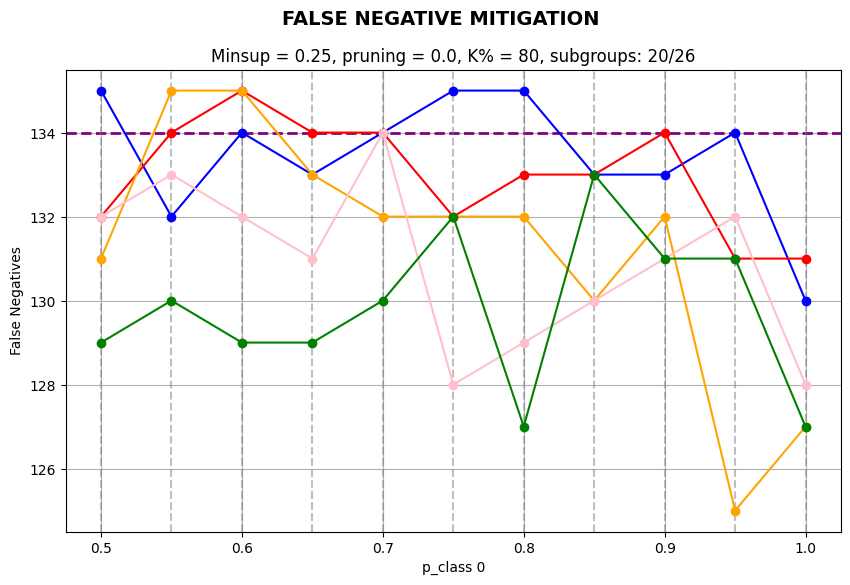

In [352]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Nome del file JSON
json_filename = "false_negatives_K_compas.json"

# Caricare i dati dal file JSON
with open(json_filename, "r") as f:
    false_negatives_data = json.load(f)

# Estrarre parametri dal JSON
run6_params = false_negatives_data.get("run6_parameters", {})
min_sup = run6_params.get("min_sup", "N/A")
percentage = run6_params.get("percentage", "N/A")
th_redundancy = run6_params.get("th_redundancy", "N/A")
L = run6_params.get("L", "N/A")
K = int((percentage / 100) * L)  # K rappresenta il numero di sottogruppi

# Lista dei valori di p da 0.5 a 1.0 con step 0.05
p_values = np.arange(0.5, 1.05, 0.05)

# Definiamo i colori per ogni N
colors = ["blue", "red", "orange", "pink", "green"]
labels = [f"N={n}K" for n in range(500, 2501, 500)]

# Creazione della figura
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle("FALSE NEGATIVE MITIGATION", fontsize=14, fontweight="bold")

# Disegniamo la linea tratteggiata "Before Mitigation"
before_mitigation = false_negatives_data.get("N=500_run6", {}).get("Before Mitigation", None)
if before_mitigation is not None:
    ax.axhline(y=before_mitigation, color="purple", linestyle="--", linewidth=2, label="Before Mitigation")

# Aggiungere linee verticali per ogni valore di p
for p in p_values:
    ax.axvline(x=p, color="gray", linestyle="--", alpha=0.5)

# Inizializziamo la lista per la legenda
legend_handles = []

# Loop sui vari N (da 500 a 2500)
for i, n in enumerate(range(500, 2501, 500)):  # da 500 a 2500 con passo 500
    N_key = f"N={n}_run6"
    if N_key not in false_negatives_data:
        continue
    
    data = false_negatives_data[N_key]
    
    # Estrarre i valori di falsi positivi per ogni p
    false_negatives = [
        data.get(f"After SMOTE N = {n} p_class 1 = {round(p, 2)}", None) 
        for p in p_values
    ]
    
    # Filtriamo solo i valori validi
    p_values_filtered = [p for j, p in enumerate(p_values) if false_negatives[j] is not None]
    false_negatives_filtered = [fp for fp in false_negatives if fp is not None]
    
    # Se ci sono dati validi, plottiamo la linea
    if false_negatives_filtered:
        line, = ax.plot(
            p_values_filtered, false_negatives_filtered, 
            marker="o", linestyle="-", color=colors[i], label=labels[i]
        )
        legend_handles.append(line)

# Impostazioni asse
ax.set_title(f"Minsup = {min_sup}, pruning = {th_redundancy}, K% = {percentage}, subgroups: {K}/{L}")
ax.set_xlabel("p_class 0")
ax.set_ylabel("False Negatives")
ax.grid()

# Aggiungere la leggenda
#ax.legend(handles=legend_handles, loc="upper right", fontsize=10, frameon=True, title="Legend")

# Mostra il grafico
plt.show()
